In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-08-05 10:48:09.692926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:48:09.810481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:48:09.811468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
NUM_WORDS = 5000
EMBEDDING_DIM = 300
MAXLEN = 500
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8
TRAIN_PATH = "/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv"

In [3]:
def remove_stop_words(dataframe):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
                 "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
                 "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
                 "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
                 "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
                 "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
                 "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
                 "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", 
                 "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're",
                 "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", 
                 "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    clean_reviews = []
    for i in range(len(dataframe)):
        review = dataframe.review_text.iloc[i]
        review = review.lower()
        clean_review = " ".join([word for word in review.split(" ") if word not in stopwords])
        
        clean_reviews.append(clean_review)
    return clean_reviews

In [4]:
def fit_tokenizer(review_list, num_words, oov_token):
    
    tokenizer = Tokenizer(num_words=num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(review_list)
    return tokenizer

def _get_padded_sequences(tokenizer, reviews, padding, maxlen):
    
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [5]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

In [6]:
train_full_data = pd.read_csv(TRAIN_PATH)

In [7]:
%%time
scaler = StandardScaler()
train_full_data["n_votes_norm"] = scaler.fit_transform(train_full_data.n_votes.to_numpy().reshape(-1, 1))
train_full_data["n_comments_norm"] =scaler.fit_transform(train_full_data.n_comments.to_numpy().reshape(-1, 1))

train_data, val_data = train_test_split(train_full_data, test_size=0.2, random_state=42)
train_labels = train_data.rating
train_sentences = remove_stop_words(train_data)
train_numerical = train_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

val_labels = val_data.rating
val_sentences = remove_stop_words(val_data)
val_numerical = val_data[["n_votes_norm", "n_comments_norm"]].to_numpy()

print(f"There are {len(train_sentences)} reviews for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(train_numerical)} numerical features for training.\n")
print(f"There are {len(val_sentences)} reviews for validation.\n")
print(f"There are {len(val_labels)} labels for validation.\n")
print(f"There are {len(val_numerical)} numerical features for validation.")

tokenizer = fit_tokenizer(train_sentences, num_words=NUM_WORDS, oov_token=OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

train_padded_seq = _get_padded_sequences(tokenizer, train_sentences, PADDING, MAXLEN)
val_padded_seq = _get_padded_sequences(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training reviews have shape: {train_padded_seq.shape}\n")
print(f"Padded validation reviews have shape: {val_padded_seq.shape}")

There are 720000 reviews for training.

There are 720000 labels for training.

There are 720000 numerical features for training.

There are 180000 reviews for validation.

There are 180000 labels for validation.

There are 180000 numerical features for validation.
Vocabulary contains 317717 words

<OOV> token included in vocabulary
Padded training reviews have shape: (720000, 500)

Padded validation reviews have shape: (180000, 500)
CPU times: user 7min 27s, sys: 2.28 s, total: 7min 30s
Wall time: 7min 32s


In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-08-05 10:56:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-05 10:56:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-05 10:56:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [9]:
%%time
embeddings_index = {}
with open("./glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 110327 words (207390 misses)
CPU times: user 16.3 s, sys: 790 ms, total: 17.1 s
Wall time: 17.4 s


# Model:

In [10]:
def cnn_gru_block(inputs, embedding_dim, word_index, embedd_matrix):
    embed = tf.keras.layers.Embedding(input_dim=len(word_index) + 1,
                                      output_dim=embedding_dim,
                                      weights=[embedd_matrix],
                                      input_length=MAXLEN,
                                      trainable=False)(inputs)
    
    # CNN head
    conv1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation="relu")(embed)
    cnn_max1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(conv1)
    cnn_flatten = tf.keras.layers.Flatten()(cnn_max1)
    cnn_drop1 = tf.keras.layers.Dropout(0.3)(cnn_flatten)
    cnn_dense1 = tf.keras.layers.Dense(256, activation="relu")(cnn_drop1)
    cnn_drop2 = tf.keras.layers.Dropout(0.3)(cnn_dense1)
    cnn_dense2 = tf.keras.layers.Dense(64, activation="relu")(cnn_drop2)
    
    # GRU head
    lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation="relu"))(embed)
    lstm_drop = tf.keras.layers.Dropout(0.3)(lstm1)
    lstm_dense = tf.keras.layers.Dense(64, activation="relu")(lstm_drop)
    
    # Merge
    concat = tf.keras.layers.concatenate([cnn_dense2, lstm_dense])
    output = tf.keras.layers.Dense(32, activation="relu")(concat)
    return output

def final_model():
    inputs = tf.keras.layers.Input(shape=MAXLEN)
    cnn_gru = cnn_gru_block(inputs, EMBEDDING_DIM, word_index, embedding_matrix)
    
    output = tf.keras.layers.Dense(6, activation="softmax")(cnn_gru)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

2022-08-05 10:59:23.626845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 10:59:23.627484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:59:23.628335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 10:59:23.629015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     95315400    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 498, 100)     90100       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 249, 100)     0           conv1d[0][0]                     
______________________________________________________________________________________________

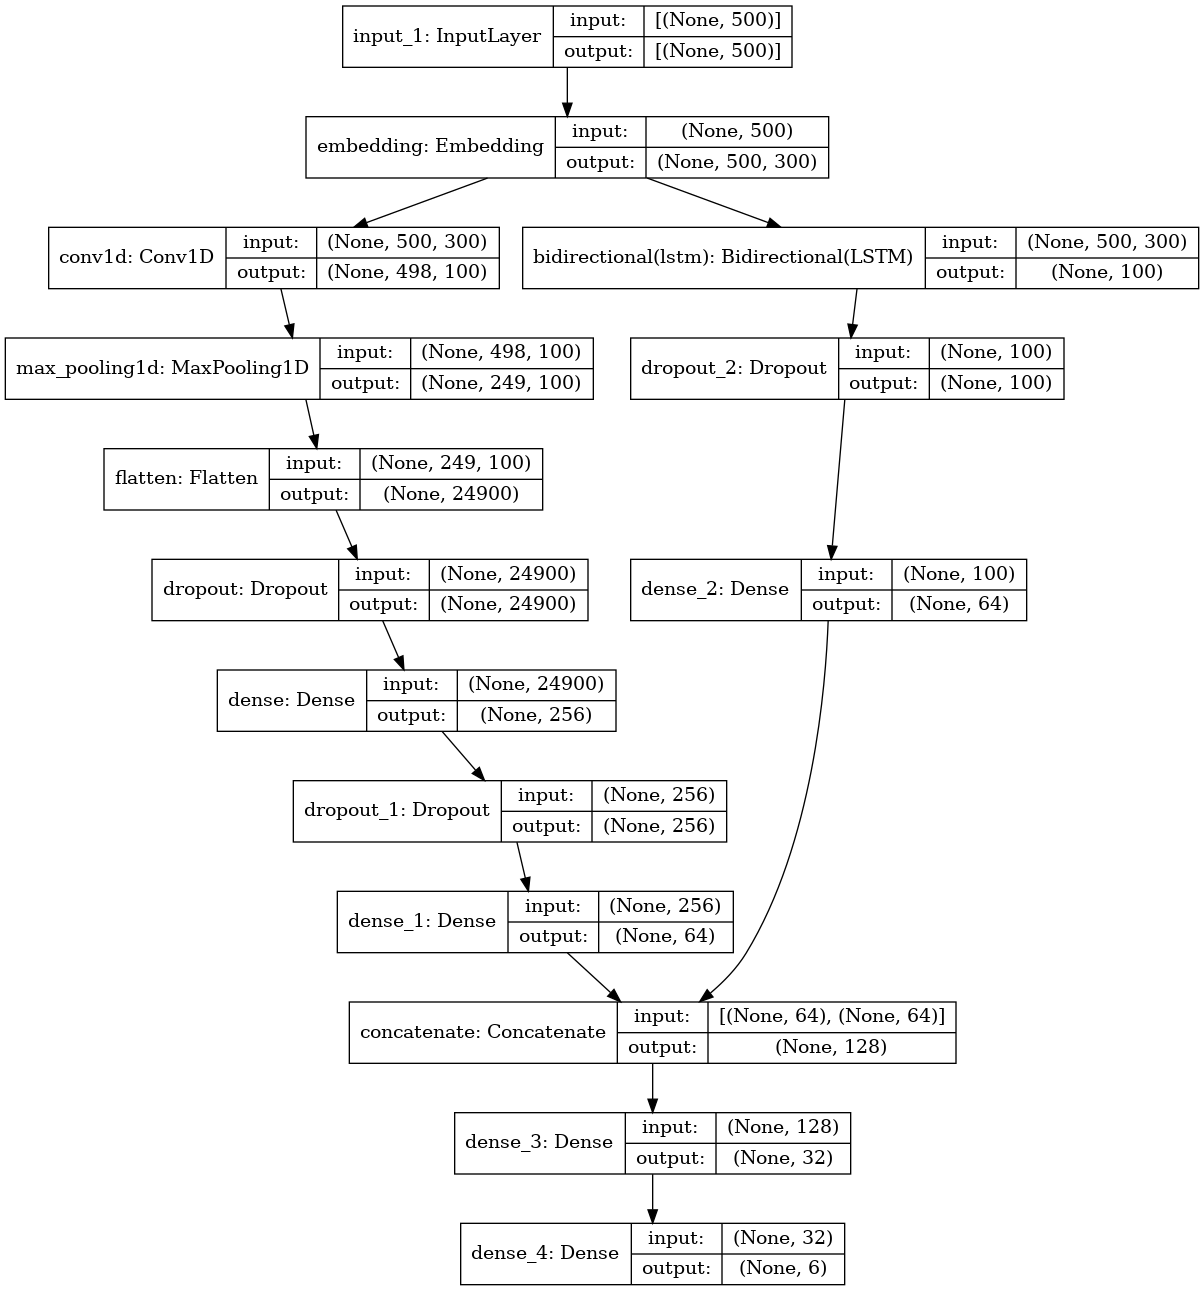

In [11]:
model = final_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy']) 
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
history = model.fit(x=train_padded_seq, 
                    y=train_labels, 
                    epochs=15,
                    batch_size=128,
                    validation_data=(val_padded_seq, val_labels),
                    callbacks=[early_stop]
                   )

2022-08-05 10:59:28.946666: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1440000000 exceeds 10% of free system memory.
2022-08-05 10:59:30.199375: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-08-05 10:59:33.854518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 535/5625 [=>............................] - ETA: 1:01:13 - loss: nan - accuracy: 0.0758